# Multi-period OPF example

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from nygrid.run_nygrid import NYGrid

In [3]:
# Set up directories
cwd = os.getcwd()
if 'dev' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/data1/by276/NYgrid-python/data/grid
Figure directory: /mnt/data1/by276/NYgrid-python/figures
Results directory: /mnt/data1/by276/NYgrid-python/results


## Read grid data

In [4]:
# Area names outside NYISO
bus_area_name = {
    1: 'NE',
    2: 'UPNY',
    3: 'DNNY',
    4: 'IESO',
    6: 'PJM',
}

# Read bus properties
filename = os.path.join(grid_data_dir, 'bus_prop.csv')
bus_prop = pd.read_csv(filename, index_col=0)
bus_prop = bus_prop[['BUS_I', 'BUS_AREA']]
bus_prop['BUS_AREA_NAME'] = bus_prop['BUS_AREA'].map(bus_area_name)

# Read NY bus-zone allocation
filename = os.path.join(grid_data_dir, 'bus_ny_type_zone_population.csv')
ny_bus_zone = pd.read_csv(filename)

ny_bus_zone = ny_bus_zone[['busIdx', 'zoneID']]
ny_bus_zone = ny_bus_zone.sort_values(by=['busIdx']).reset_index(drop=True).set_index('busIdx')

# Combine data for NY and outside NY
bus_zone_alloc = pd.merge(bus_prop, ny_bus_zone, left_on='BUS_I', right_index=True, how='left')
bus_zone_alloc.loc[bus_zone_alloc['zoneID'].isna(), 'zoneID'] = bus_zone_alloc.loc[bus_zone_alloc['zoneID'].isna(), 'BUS_AREA_NAME']
bus_zone_alloc = bus_zone_alloc[['BUS_I', 'zoneID']]
# bus_zone_alloc['BUS_I'] = 'Bus'+bus_zone_alloc['BUS_I'].astype(str)

# Create a dict where key is busIdx and value is zoneID
bus_zone_alloc = bus_zone_alloc.set_index('BUS_I').to_dict()['zoneID']
bus_names = list(bus_zone_alloc.keys())
bus_names_str = [f'Bus{i}' for i in bus_names]

In [5]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


In [6]:
load_profile.sum(axis=1).sort_values(ascending=False)

TimeStamp
2018-08-29 16:00:00    93203.379573
2018-08-29 15:00:00    93195.481205
2018-08-28 16:00:00    93096.897866
2018-08-28 17:00:00    92926.644148
2018-08-29 14:00:00    92834.789049
                           ...     
2018-05-13 05:00:00    35697.114653
2018-10-14 04:00:00    35637.438092
2018-05-14 03:00:00    35606.429683
2018-05-13 03:00:00    35419.794164
2018-05-13 04:00:00    35330.279322
Length: 8760, dtype: float64

### Read PyPower Case from CSV

#### Generator data

In [8]:
# Read generator to bus allocation
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info['genIdx'] = gen_info.index
# gen_info['genIdx'] = 'Gen'+gen_info['genIdx'].astype(str)
gen_info = gen_info[['genIdx', 'NYISOName', 'Zone', 'UnitType', 'FuelType', 'maxPower', 'minPower']].set_index('genIdx')
gen_info

,NYISOName,Zone,UnitType,FuelType,maxPower,minPower
genIdx,,,,,,
0,59 St. GT 1,J,Combustion Turbine,Kerosene,17.1,0.0
1,74 St. GT 1,J,Combustion Turbine,Kerosene,18.5,0.0
2,74 St. GT 2,J,Combustion Turbine,Kerosene,18.5,0.0
3,Allegany,B,Combined Cycle,Natural Gas,66.0,11.0
4,Allied Frozen Storage,A,Internal Combustion,Natural Gas,0.1,0.0
...,...,...,...,...,...,...
222,Vernon Blvd 3,J,Combustion Turbine,Natural Gas,42.0,15.0
223,Wading River 1,K,Combustion Turbine,Fuel Oil 2,102.0,9.0
224,Wading River 2,K,Combustion Turbine,Fuel Oil 2,94.0,7.8


In [9]:
# Read generator properties
filename = os.path.join(grid_data_dir, 'gen_prop.csv')
gen_prop = pd.read_csv(filename, index_col=0)
gen_prop = gen_prop[['GEN_BUS', 'PMAX', 'PMIN']]
gen_prop['zoneID'] = gen_prop['GEN_BUS'].map(bus_zone_alloc)

# Read generator fuel type
filename = os.path.join(grid_data_dir, 'genfuel_prop.csv')
gen_fuel = pd.read_csv(filename, index_col=0)
gen_prop = pd.merge(gen_prop, gen_fuel, left_index=True, right_index=True)

# Add generator name
gen_prop = pd.merge(gen_prop, gen_info[['NYISOName']], left_index=True, right_index=True, how='left')

# Fill missing name with GEN_FUEL, zoneID, and GEN_BUS
gen_prop['NYISOName'] = gen_prop['NYISOName'].fillna(gen_prop['GEN_FUEL'] + '_' + gen_prop['zoneID'])

# Add suffix to duplicate names
gen_prop['NYISOName'] = gen_prop['NYISOName'].astype(str) + '_' + gen_prop.groupby('NYISOName').cumcount().astype(str)
gen_prop

,GEN_BUS,PMAX,PMIN,zoneID,GEN_FUEL,NYISOName
0,82,17.100000,0.0,J,Combustion Turbine,59 St. GT 1_0
1,82,18.500000,0.0,J,Combustion Turbine,74 St. GT 1_0
2,82,18.500000,0.0,J,Combustion Turbine,74 St. GT 2_0
3,62,66.000000,11.0,B,Combined Cycle,Allegany_0
4,55,0.100000,0.0,A,Internal Combustion,Allied Frozen Storage_0
...,...,...,...,...,...,...
298,37,7.465825,0.0,F,Other,Other_F_3
299,73,5.723800,0.0,G,Other,Other_G_0
300,74,37.142482,0.0,H,Other,Other_H_0
301,79,76.898002,0.0,K,Other,Other_K_0


#### Storage data

In [10]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
storage_prop = pd.read_csv(filename, index_col=0)
storage_prop['zoneID'] = storage_prop['ESR_BUS'].map(bus_zone_alloc)
storage_prop = storage_prop[['ESR_NAME', 'zoneID', 'ESR_CRG_MAX', 'ESR_DIS_MAX', 
                             'ESR_SOC_MAX', 'ESR_CRG_EFF', 'ESR_DIS_EFF']]

# Round to integer
storage_prop['ESR_CRG_MAX'] = storage_prop['ESR_CRG_MAX'].round(0).astype(np.uint32)
storage_prop['ESR_DIS_MAX'] = storage_prop['ESR_DIS_MAX'].round(0).astype(np.uint32)
storage_prop['ESR_SOC_MAX'] = storage_prop['ESR_SOC_MAX'].round(0).astype(np.uint32)
storage_prop

,ESR_NAME,zoneID,ESR_CRG_MAX,ESR_DIS_MAX,ESR_SOC_MAX,ESR_CRG_EFF,ESR_DIS_EFF
0,Gilboa 1 (IIFO - 1/1/2019),F,280,292,3000,0.67,0.67
1,Gilboa 2,F,280,293,3000,0.67,0.67
2,Gilboa 3,F,280,292,3000,0.67,0.67
3,Gilboa 4,F,280,292,3000,0.67,0.67
4,Lewiston PS,A,230,240,2880,0.59,0.59
5,North County Energy Storage,E,20,20,200,0.85,0.85
6,zzAgg_J_ES__1,J,2,2,8,0.85,0.85
7,zzAgg_K_FC__1,K,18,18,74,0.85,0.85
8,A_ESR_Standalone,A,300,300,1200,0.85,0.85
9,B_ESR_Standalone,B,180,180,720,0.85,0.85


In [ ]:
filename = os.path.join(grid_data_dir, 'branch_prop.csv')
branch_prop = pd.read_csv(filename, index_col=0)
branch_prop['From_Zone'] = branch_prop['F_BUS'].map(bus_zone_alloc)
branch_prop['To_Zone'] = branch_prop['T_BUS'].map(bus_zone_alloc)
branch_prop = branch_prop[['From_Zone', 'To_Zone', 'RATE_A']]
# Replace default value 0 (unlimited) with 999999
branch_prop.loc[branch_prop['RATE_A'] == 0, 'RATE_A'] = 9999

# Remove lines that are from and to the same zone
branch_prop = branch_prop[branch_prop['From_Zone'] != branch_prop['To_Zone']]

# Add line name and category
branch_prop['Name'] = [f'AC_{f}_{t}' for f, t in zip(branch_prop['From_Zone'], branch_prop['To_Zone'])]
branch_prop['Category'] = 'AC'

# Round to integer
branch_prop['RATE_A'] = branch_prop['RATE_A'].round(0).astype(np.uint32)
branch_prop = branch_prop.rename(columns={'RATE_A': 'Capacity'})
branch_prop

#### AC line data

In [11]:
filename = os.path.join(grid_data_dir, 'branch_prop.csv')
branch_prop = pd.read_csv(filename, index_col=0)
branch_prop['From_Zone'] = branch_prop['F_BUS'].map(bus_zone_alloc)
branch_prop['To_Zone'] = branch_prop['T_BUS'].map(bus_zone_alloc)
branch_prop = branch_prop[['From_Zone', 'To_Zone', 'RATE_A']]
# Replace default value 0 (unlimited) with 999999
branch_prop.loc[branch_prop['RATE_A'] == 0, 'RATE_A'] = 9999

# Remove lines that are from and to the same zone
branch_prop = branch_prop[branch_prop['From_Zone'] != branch_prop['To_Zone']]

# Add line name and category
branch_prop['Name'] = [f'AC_{f}_{t}' for f, t in zip(branch_prop['From_Zone'], branch_prop['To_Zone'])]
branch_prop['Category'] = 'AC'

# Round to integer
branch_prop['RATE_A'] = branch_prop['RATE_A'].round(0).astype(np.uint32)
branch_prop = branch_prop.rename(columns={'RATE_A': 'Capacity'})
branch_prop

,From_Zone,To_Zone,Capacity,Name,Category
0,NE,F,200,AC_NE_F,AC
1,NE,G,1400,AC_NE_G,AC
2,F,E,9999,AC_F_E,AC
3,F,G,9999,AC_F_G,AC
5,F,E,9999,AC_F_E,AC
7,E,G,9999,AC_E_G,AC
11,F,E,9999,AC_F_E,AC
13,F,E,9999,AC_F_E,AC
16,E,C,9999,AC_E_C,AC
18,E,D,9999,AC_E_D,AC


#### DC line data

In [12]:
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0)
dcline_prop['From_Zone'] = dcline_prop['DC_F_BUS'].map(bus_zone_alloc)
dcline_prop['To_Zone'] = dcline_prop['DC_T_BUS'].map(bus_zone_alloc)
dcline_prop = dcline_prop[['From_Zone', 'To_Zone', 'DC_PMAX']]

# Add line name and category
dcline_prop['Name'] = [f'DC_{f}_{t}' for f, t in zip(dcline_prop['From_Zone'], dcline_prop['To_Zone'])]
dcline_prop['Category'] = 'DC'

# Round to integer
dcline_prop['DC_PMAX'] = dcline_prop['DC_PMAX'].round(0).astype(np.uint32)
dcline_prop = dcline_prop.rename(columns={'DC_PMAX': 'Capacity'})
dcline_prop

,From_Zone,To_Zone,Capacity,Name,Category
0,NE,K,530,DC_NE_K,DC
1,PJM,K,660,DC_PJM_K,DC
2,PJM,J,660,DC_PJM_J,DC
3,PJM,J,660,DC_PJM_J,DC
4,D,J,1250,DC_D_J,DC
5,E,J,1300,DC_E_J,DC


#### Interface data

In [13]:
filename = os.path.join(grid_data_dir, 'if_lims_prop.csv')
if_lim_prop = pd.read_csv(filename, index_col=0)
if_lim_prop['From_Zone'] = [name.split('-')[0] for name in if_lim_prop['IF_NAME']]
if_lim_prop['To_Zone'] = [name.split('-')[1] for name in if_lim_prop['IF_NAME']]
if_lim_prop['Forward_Cap'] = if_lim_prop['IF_MAX'].round(0).astype(np.uint32)
if_lim_prop['Backward_Cap'] = (if_lim_prop['IF_MIN']*-1).round(0).astype(np.uint32)

if_lim_prop = if_lim_prop.drop(columns=['IF_NAME', 'IF_MAX', 'IF_MIN'])

# Add interfaces where lines exist

if_lim_prop

,From_Zone,To_Zone,Forward_Cap,Backward_Cap
0,A,B,3150,9999
1,B,C,9999,9999
2,C,E,6800,9999
3,D,E,3150,1600
4,E,F,2465,9999
5,E,G,3185,1600
6,F,G,5400,5400
7,G,H,5700,9999
8,H,I,8450,8450
9,I,J,4350,9999


## Multi-period OPF

### Without initial conditions

In [6]:
# Only run for one day
d = 240
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-29 00:00:00
End time: 2018-08-30 23:00:00


In [7]:
# Read DC line property file
filename = os.path.join(grid_data_dir, 'dcline_prop.csv')
dcline_prop = pd.read_csv(filename, index_col=0).to_numpy()
dcline_prop


array([[ 2.10000000e+01,  8.00000000e+01,  1.00000000e+00,
         1.26666670e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.01000000e+00,  1.00000000e+00,
        -5.30000000e+02,  5.30000000e+02, -1.00000000e+02,
         1.00000000e+02, -1.00000000e+02,  1.00000000e+02,
         0.00000000e+00,  0.00000000e+00],
       [ 1.24000000e+02,  7.90000000e+01,  1.00000000e+00,
         6.60000000e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.01000000e+00,  1.00000000e+00,
        -6.60000000e+02,  6.60000000e+02, -1.00000000e+02,
         1.00000000e+02, -1.00000000e+02,  1.00000000e+02,
         0.00000000e+00,  0.00000000e+00],
       [ 1.25000000e+02,  8.10000000e+01,  1.00000000e+00,
         5.99166667e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.01000000e+00,  1.00000000e+00,
        -6.60000000e+02,  6.60000000e+02, -1.00000000e+02,
         1.00000000e+02, -1.00000000e+02,  1.00000000e+02,
         0.00000000e+00,  0.0

In [8]:
filename = os.path.join(grid_data_dir, 'esr_prop.csv')
esr_prop = pd.read_csv(filename, index_col=0).to_numpy()
esr_prop

array([['Gilboa 1 (IIFO - 1/1/2019)', 42, 1, 280.0, 291.8, 0.67, 0.67, 0,
        3000, 1500, 1500, 0.005, 0.005],
       ['Gilboa 2', 42, 1, 280.0, 292.7, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Gilboa 3', 42, 1, 280.0, 291.9, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Gilboa 4', 42, 1, 280.0, 292.5, 0.67, 0.67, 0, 3000, 1500, 1500,
        0.005, 0.005],
       ['Lewiston PS', 56, 1, 230.0, 240.0, 0.59, 0.59, 0, 2880, 1440,
        1440, 0.005, 0.005],
       ['North County Energy Storage', 47, 1, 20.0, 20.0, 0.85, 0.85, 0,
        200, 100, 100, 0.005, 0.005],
       ['zzAgg_J_ES__1', 82, 1, 2.0, 2.0, 0.85, 0.85, 0, 8, 4, 4, 0.005,
        0.005],
       ['zzAgg_K_FC__1', 80, 1, 18.5, 18.5, 0.85, 0.85, 0, 74, 37, 37,
        0.005, 0.005],
       ['A_ESR_Standalone', 56, 1, 300.0, 300.0, 0.85, 0.85, 0, 1200,
        600, 600, 0.005, 0.005],
       ['B_ESR_Standalone', 53, 1, 180.0, 180.0, 0.85, 0.85, 0, 720, 360,
        360, 0.005, 0.0

#### Without ESR

In [9]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_wo_esr.set_load_sch(load_profile)
nygrid_sim_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_wo_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_wo_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_wo_esr.solve_dc_opf()

# Get results
results_0_wo_esr = nygrid_sim_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 315
Number of branches: 94
Number of time periods: 48
Number of variables: 65520
Number of constraints: 80250
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp2tghhbtx.pyomo.lp
Reading time = 0.26 seconds
x65521: 80251 rows, 65521 columns, 403183 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80251 rows, 65521 columns and 403183 nonzeros
Model fingerprint: 0x5e23ac2f
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 73893 rows and 49755 columns
Presolve tim

In [10]:
print("s_ramp_up", results_0_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_0_wo_esr['s_load_shed'].sum())
print("s_if_max", results_0_wo_esr['s_if_max'].sum())
print("s_if_min", results_0_wo_esr['s_if_min'].sum())
print("s_br_max", results_0_wo_esr['s_br_max'].sum())
print("s_br_min", results_0_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [11]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_w_esr.set_load_sch(load_profile)
nygrid_sim_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_w_esr.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_w_esr.set_gen_init_data(gen_init=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_w_esr.solve_dc_opf()

# Get results
results_0_w_esr = nygrid_sim_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 345
Number of branches: 94
Number of time periods: 48
Number of variables: 74160
Number of constraints: 94620
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpj8le5m_j.pyomo.lp
Reading time = 0.27 seconds
x74161: 94621 rows, 74161 columns, 433243 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 94621 rows, 74161 columns and 433243 nonzeros
Model fingerprint: 0x3844c0da
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 86706 rows and 53988 columns
Presolve tim

In [12]:
print("s_ramp_up", results_0_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_0_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_0_w_esr['s_over_gen'].sum())
print("s_load_shed", results_0_w_esr['s_load_shed'].sum())
print("s_if_max", results_0_w_esr['s_if_max'].sum())
print("s_if_min", results_0_w_esr['s_if_min'].sum())
print("s_br_max", results_0_w_esr['s_br_max'].sum())
print("s_br_min", results_0_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


In [13]:
ii = 5
print('total', nygrid_sim_w_esr.model.PG[:, nygrid_sim_w_esr.esr_idx[ii]]())
print('discharging', nygrid_sim_w_esr.model.esrPDis[:, ii]())
print('charging', nygrid_sim_w_esr.model.esrPCrg[:, ii]())
print('SOC', nygrid_sim_w_esr.model.esrSOC[:, ii]())

total [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08442906574394492, -0.2, -0.2, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17647058823529393, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, -0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
discharging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
charging [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08442906574394492, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1764705882352939, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
SOC [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0717647058823532, 1.241764705882353, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.411764705882353, 1.1764705882352942, 0.941176

In [14]:
print(f'Total cost: {results_0_wo_esr["total_cost"].sum():.2f}, {results_0_w_esr["total_cost"].sum():.2f}')
print(f'Gen cost: {results_0_wo_esr["gen_cost"].sum():.2f}, {results_0_w_esr["gen_cost"].sum():.2f}')
print(f'Over generation penalty: {results_0_wo_esr["over_gen_penalty"].sum():.2f}, {results_0_w_esr["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0_wo_esr["load_shed_penalty"].sum():.2f}, {results_0_w_esr["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0_wo_esr["ramp_up_penalty"].sum():.2f}, {results_0_w_esr["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0_wo_esr["ramp_down_penalty"].sum():.2f}, {results_0_w_esr["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0_wo_esr["if_max_penalty"].sum():.2f}, {results_0_w_esr["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0_wo_esr["if_min_penalty"].sum():.2f}, {results_0_w_esr["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0_wo_esr["br_max_penalty"].sum():.2f}, {results_0_w_esr["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0_wo_esr["br_min_penalty"].sum():.2f}, {results_0_w_esr["br_min_penalty"].sum():.2f}')

Total cost: 115776759.47, 113972771.96
Gen cost: 115776759.47, 113972771.96
Over generation penalty: 0.00, 0.00
Load shed penalty: 0.00, 0.00
Ramp up penalty: 0.00, 0.00
Ramp down penalty: 0.00, 0.00
Interface max penalty: 0.00, 0.00
Interface min penalty: 0.00, 0.00
Branch max penalty: 0.00, 0.00
Branch min penalty: 0.00, 0.00


#### Results

In [15]:
lmp_wo_esr = results_0_wo_esr['LMP']
lmp_wo_esr.columns = bus_names

lmp_w_esr = results_0_w_esr['LMP']
lmp_w_esr.columns = bus_names

# Aggregate LMPs by zone
lmp_wo_esr_zone = lmp_wo_esr.groupby(bus_zone_alloc, axis=1).mean()
lmp_w_esr_zone = lmp_w_esr.groupby(bus_zone_alloc, axis=1).mean()

In [16]:
lmp_wo_esr_zone

,A,B,C,D,E,F,G,H,I,IESO,J,K,NE,PJM
2018-08-29 00:00:00,37.995083,38.021767,38.471975,37.954170,37.999146,44.211268,39.088105,37.845248,37.951269,37.973756,38.222228,38.205363,42.713578,38.168391
2018-08-29 01:00:00,33.360166,33.384866,33.801584,33.322297,33.363927,39.113949,34.371882,33.221477,33.319611,33.340426,33.570415,33.554804,37.727668,33.520582
2018-08-29 02:00:00,29.951431,29.979187,30.359239,29.908997,29.914689,34.872577,31.109845,30.154935,30.653992,30.017928,30.297413,30.653992,33.770600,30.281885
2018-08-29 03:00:00,31.185580,31.209170,31.607172,31.149412,31.189172,36.680933,32.151855,31.053120,31.146847,31.166727,31.386386,31.371476,35.356917,31.338791
2018-08-29 04:00:00,29.809459,29.838453,30.191478,29.765193,29.750657,34.180195,31.030267,30.201165,30.652793,29.923126,30.225563,30.652793,33.256281,30.229516
2018-08-29 05:00:00,33.427662,33.440844,33.784916,33.557524,33.367693,38.380489,34.272228,33.275411,33.361125,33.408967,33.695120,33.564433,37.181314,33.536179
2018-08-29 06:00:00,28.571352,28.613567,29.004113,28.507073,28.428427,32.773963,30.378861,29.644386,30.106333,28.860906,29.330667,30.106333,32.066523,29.393041
2018-08-29 07:00:00,27.064700,27.106953,27.497846,27.000364,26.921647,31.271053,28.873818,28.138690,28.601048,27.354512,27.824691,28.601048,30.562983,27.887121
2018-08-29 08:00:00,27.810228,28.539003,29.127757,28.699082,28.762462,30.877700,29.750248,29.405126,29.620862,28.221190,28.885371,29.620862,30.549363,29.293741
2018-08-29 09:00:00,32.210760,33.926672,35.065714,34.454591,34.565986,36.692309,35.618749,35.291121,35.222600,32.998374,34.307563,35.358190,36.387202,35.196225


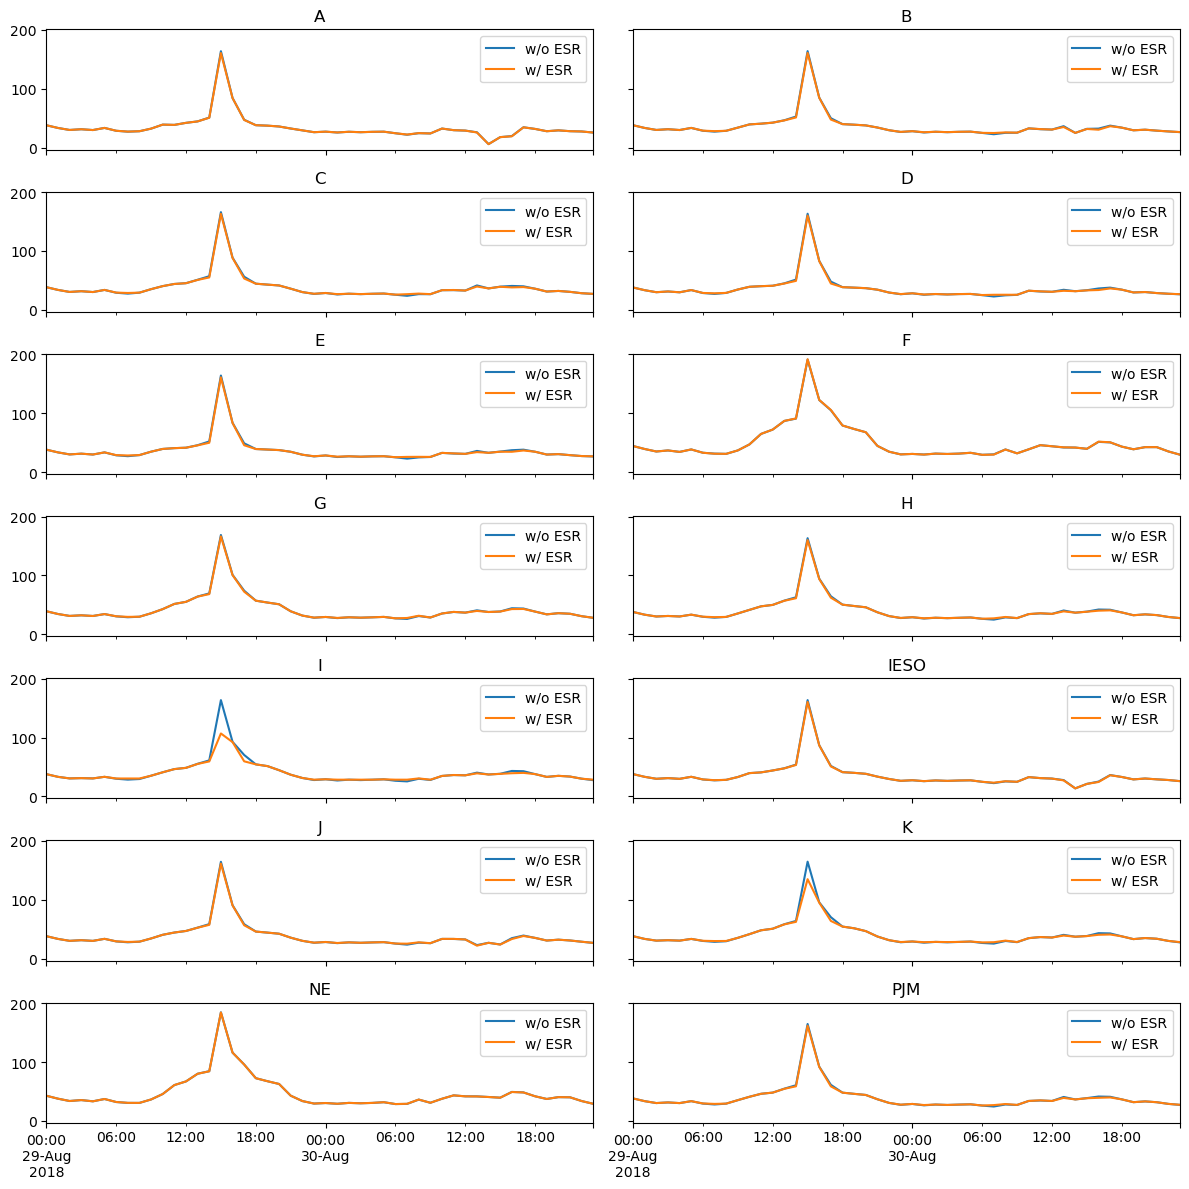

In [17]:
fig, axs = plt.subplots(7, 2, figsize=(12, 12), sharex='all', sharey='all')
# Plot LMPs w/o ESR
for i, ax in enumerate(axs.flat):
    lmp_wo_esr_zone.iloc[:, i].plot(ax=ax, label='w/o ESR')
    lmp_w_esr_zone.iloc[:, i].plot(ax=ax, label='w/ ESR')
    ax.set_title(lmp_w_esr_zone.columns[i])
    ax.legend()
    
fig.tight_layout()

<Axes: title={'center': 'Zonal Load'}, xlabel='TimeStamp'>

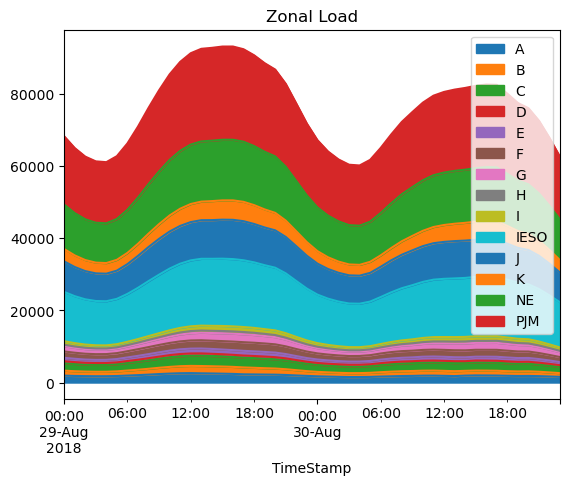

In [18]:
load_profile.columns = bus_names
load_profile_zone = load_profile.groupby(bus_zone_alloc, axis=1).sum()
load_profile_zone[start_datetime:end_datetime].plot.area(title="Zonal Load")

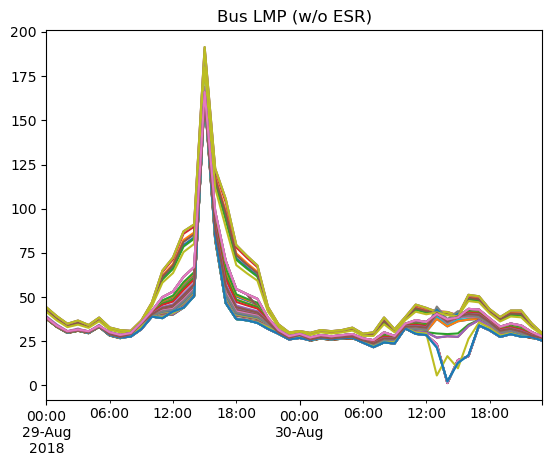

In [19]:
results_0_wo_esr['LMP'].plot(legend=False, title="Bus LMP (w/o ESR)")
plt.show()

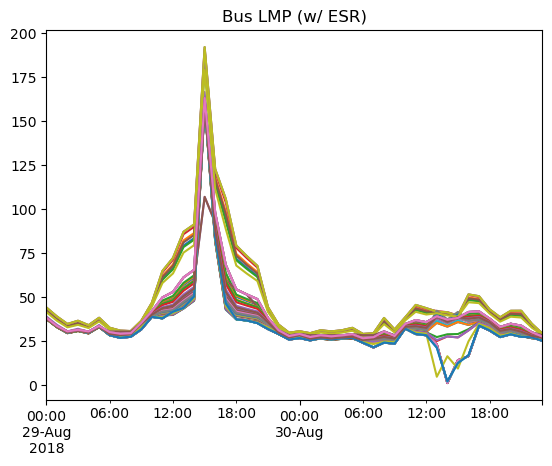

In [20]:
results_0_w_esr['LMP'].plot(legend=False, title="Bus LMP (w/ ESR)")
plt.show()

In [21]:
gen_max = genmax_profile[start_datetime:end_datetime]
gen_pg = results_0_wo_esr['PG'].iloc[:, :303]
gen_pg.columns = gen_max.columns
surplus = gen_max - gen_pg
surplus

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-29 00:00:00,17.1,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 01:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 02:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 03:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 04:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,-8.881784e-16,-8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 05:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,0.0,...,0.0,0.0,-2.220446e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 06:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,-3.552714e-15,0.0,0.000000e+00
2018-08-29 07:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
2018-08-29 08:00:00,17.1,18.5,18.5,0.0,0.0,0.0,20.0,0.0,0.0,152.0,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.881784e-16,0.0,0.000000e+00,0.0,0.000000e+00


### With initial conditions

In [22]:
# Only run for one day
d = d+1
start_datetime = timestamp_list[d]
end_datetime = start_datetime + timedelta(hours=47)
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')

Start time: 2018-08-30 00:00:00
End time: 2018-08-31 23:00:00


#### Without ESR

In [23]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_wo_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=None,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_wo_esr.set_load_sch(load_profile)
nygrid_sim_1_wo_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_wo_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_wo_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_wo_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_wo_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_wo_esr.relax_external_branch_lim()

# Set generator initial condition
# last_gen = results_0_wo_esr['PG'].iloc[-1,:].to_numpy().squeeze()
last_gen = results_0_wo_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_wo_esr.set_gen_init_data(gen_init=last_gen)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_wo_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_wo_esr.solve_dc_opf()

# Get results
results_1_wo_esr = nygrid_sim_1_wo_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 315
Number of branches: 94
Number of time periods: 48
Number of variables: 65520
Number of constraints: 80880
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmp95bqgm04.pyomo.lp
Reading time = 0.25 seconds
x65521: 80881 rows, 65521 columns, 404443 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 80881 rows, 65521 columns and 404443 nonzeros
Model fingerprint: 0x4172cb83
Coefficient statistics:
  Matrix range     [3e-06, 1e+00]
  Objective range  [3e+00, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 74623 rows and 49855 columns
Presolve tim

In [24]:
print("s_ramp_up", results_1_wo_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_wo_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_wo_esr['s_over_gen'].sum())
print("s_load_shed", results_1_wo_esr['s_load_shed'].sum())
print("s_if_max", results_1_wo_esr['s_if_max'].sum())
print("s_if_min", results_1_wo_esr['s_if_min'].sum())
print("s_br_max", results_1_wo_esr['s_br_max'].sum())
print("s_br_min", results_1_wo_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


#### With ESR

In [25]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim_1_w_esr = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%m-%d-%Y %H'), 
                    end_datetime=end_datetime.strftime('%m-%d-%Y %H'),
                    dcline_prop=dcline_prop,
                    esr_prop=esr_prop,
                    verbose=True)

# Set load and generation time series data
nygrid_sim_1_w_esr.set_load_sch(load_profile)
nygrid_sim_1_w_esr.set_gen_mw_sch(gen_profile)
nygrid_sim_1_w_esr.set_gen_max_sch(genmax_profile)
nygrid_sim_1_w_esr.set_gen_min_sch(genmin_profile)
nygrid_sim_1_w_esr.set_gen_ramp_sch(genramp30_profile)
nygrid_sim_1_w_esr.set_gen_cost_sch(gencost0_profile, gencost1_profile)

# Relax branch flow limits
nygrid_sim_1_w_esr.relax_external_branch_lim()

# Set generator initial condition
# last_gen = results_0_w_esr['PG'].iloc[-1,:].to_numpy().squeeze()
last_gen = results_0_w_esr['PG'].loc[start_datetime].to_numpy().squeeze()
nygrid_sim_1_w_esr.set_gen_init_data(gen_init=last_gen)

# Set options
# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    'PenaltyForBranchMwViolation': 10_000,
    'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1_w_esr.set_options(options)

# Solve DC OPF
nygrid_sim_1_w_esr.solve_dc_opf()

# Get results
results_1_w_esr = nygrid_sim_1_w_esr.get_results_dc_opf()

Number of buses: 57
Number of generators: 345
Number of branches: 94
Number of time periods: 48
Number of variables: 74160
Number of constraints: 95310
Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpd0jf94ur.pyomo.lp
Reading time = 0.28 seconds
x74161: 95311 rows, 74161 columns, 434623 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 95311 rows, 74161 columns and 434623 nonzeros
Model fingerprint: 0x8f0f64a1
Coefficient statistics:
  Matrix range     [3e-06, 2e+00]
  Objective range  [5e-01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-17, 2e+04]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 87482 rows and 54076 columns
Presolve tim

In [26]:
print("s_ramp_up", results_1_w_esr['s_ramp_up'].sum())
print("s_ramp_down", results_1_w_esr['s_ramp_down'].sum())
print("s_over_gen", results_1_w_esr['s_over_gen'].sum())
print("s_load_shed", results_1_w_esr['s_load_shed'].sum())
print("s_if_max", results_1_w_esr['s_if_max'].sum())
print("s_if_min", results_1_w_esr['s_if_min'].sum())
print("s_br_max", results_1_w_esr['s_br_max'].sum())
print("s_br_min", results_1_w_esr['s_br_min'].sum())

s_ramp_up 0.0
s_ramp_down 0.0
s_over_gen 0.0
s_load_shed 0.0
s_if_max 0.0
s_if_min 0.0
s_br_max 0.0
s_br_min 0.0


## Process the results

In [27]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [28]:
# Format results
results_pg_0_wo_esr = results_0_wo_esr['PG']
thermal_pg_0_wo_esr = results_pg_0_wo_esr.iloc[:, :num_thermal]
thermal_pg_0_wo_esr = thermal_pg_0_wo_esr.rename(columns=gen_rename)
print(thermal_pg_0_wo_esr.head())

results_pg_0_w_esr = results_0_w_esr['PG']
thermal_pg_0_w_esr = results_pg_0_w_esr.iloc[:, :num_thermal]
thermal_pg_0_w_esr = thermal_pg_0_w_esr.rename(columns=gen_rename)
print(thermal_pg_0_w_esr.head())

results_pg_1_wo_esr = results_1_wo_esr['PG']
thermal_pg_1_wo_esr = results_pg_1_wo_esr.iloc[:, :num_thermal]
thermal_pg_1_wo_esr = thermal_pg_1_wo_esr.rename(columns=gen_rename)
print(thermal_pg_1_wo_esr.head())

results_pg_1_w_esr = results_1_w_esr['PG']
thermal_pg_1_w_esr = results_pg_1_w_esr.iloc[:, :num_thermal]
thermal_pg_1_w_esr = thermal_pg_1_w_esr.rename(columns=gen_rename)
print(thermal_pg_1_w_esr.head())

                     59 St.  GT 1  74 St.  GT 1  74 St.  GT 2  Allegany  \
2018-08-29 00:00:00           0.0           0.0           0.0      66.0   
2018-08-29 01:00:00           0.0           0.0           0.0      66.0   
2018-08-29 02:00:00           0.0           0.0           0.0      66.0   
2018-08-29 03:00:00           0.0           0.0           0.0      66.0   
2018-08-29 04:00:00           0.0           0.0           0.0      66.0   

                     Allied Frozen Storage  Arthur Kill Cogen  \
2018-08-29 00:00:00                    0.1               11.1   
2018-08-29 01:00:00                    0.1               11.1   
2018-08-29 02:00:00                    0.1               11.1   
2018-08-29 03:00:00                    0.1               11.1   
2018-08-29 04:00:00                    0.1               11.1   

                     Arthur Kill GT 1  Arthur Kill ST 2  Arthur Kill ST 3  \
2018-08-29 00:00:00              20.0             349.0             539.0   
2018

In [29]:
def plot_gen(thermal_pg, gen_profile, genmax_profile, genmin_profile, i, title=None, ax=None):

    ax.plot(thermal_pg.index, thermal_pg.iloc[:, i], marker='*', label='OPF')
    ax.plot(thermal_pg.index, gen_profile[start_datetime:end_datetime].iloc[:,i], marker='o', label='historical')
    ax.plot(thermal_pg.index, genmax_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='max')
    ax.plot(thermal_pg.index, genmin_profile[start_datetime:end_datetime].iloc[:,i], linestyle='--', label='min')
    ax.legend()
    ax.set_title(title)

    return ax

In [30]:
gen_profile[start_datetime:end_datetime]

,Gen1,Gen2,Gen3,Gen4,Gen5,Gen6,Gen7,Gen8,Gen9,Gen10,...,Gen294,Gen295,Gen296,Gen297,Gen298,Gen299,Gen300,Gen301,Gen302,Gen303
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-08-30 00:00:00,0.0,0.0,0.0,66.0,0.0,11.1,0.0,349.0,539.0,1.0,...,2.660778,34.312951,1.773852,0.388030,7.982334,6.651945,5.099825,33.093428,68.515037,24.390466
2018-08-30 01:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.648160,34.150228,1.765440,0.386190,7.944479,6.620400,5.075640,32.936488,68.190116,24.274798
2018-08-30 02:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.656572,34.258710,1.771048,0.387417,7.969716,6.641430,5.091763,33.041115,68.406730,24.351910
2018-08-30 03:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.656572,34.258710,1.771048,0.387417,7.969716,6.641430,5.091763,33.041115,68.406730,24.351910
2018-08-30 04:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.643954,34.095987,1.762636,0.385577,7.931861,6.609884,5.067578,32.884175,68.081809,24.236243
2018-08-30 05:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,96.0,1.0,1.0,...,2.665825,34.378041,1.777217,0.388766,7.997476,6.664564,5.109499,33.156204,68.645005,24.436733
2018-08-30 06:00:00,0.0,0.0,0.0,11.0,0.0,0.0,0.0,96.0,1.0,1.0,...,2.664143,34.356344,1.776095,0.388521,7.992429,6.660358,5.106274,33.135279,68.601682,24.421311
2018-08-30 07:00:00,0.0,0.0,0.0,11.0,0.0,0.0,0.0,151.2,1.0,1.0,...,2.692744,34.725184,1.795163,0.392692,8.078233,6.731861,5.161094,33.491009,69.338170,24.683491
2018-08-30 08:00:00,0.0,0.0,0.0,66.0,0.0,0.0,0.0,349.0,223.7,1.0,...,2.736488,35.289292,1.824325,0.399071,8.209464,6.841220,5.244935,34.035068,70.464564,25.084472


NYISOName              Allegany
PTID                      23514
Zone                          B
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                42.5083
Longitude              -78.0661
maxPower                   66.0
minPower                   11.0
maxRampAgc                  6.6
maxRamp10                  66.0
maxRamp30                  66.0
maxRamp60                  66.0
HeatRateLM_1           8.218122
HeatRateLM_0         -14.577671
HeatRateLM_R2          0.862443
HeatRateQM_2          -0.094773
HeatRateQM_1           15.20904
HeatRateQM_0        -125.857658
HeatRateQM_R2          0.891407
useQM                         1
start-time                  10m
Name: 3, dtype: object


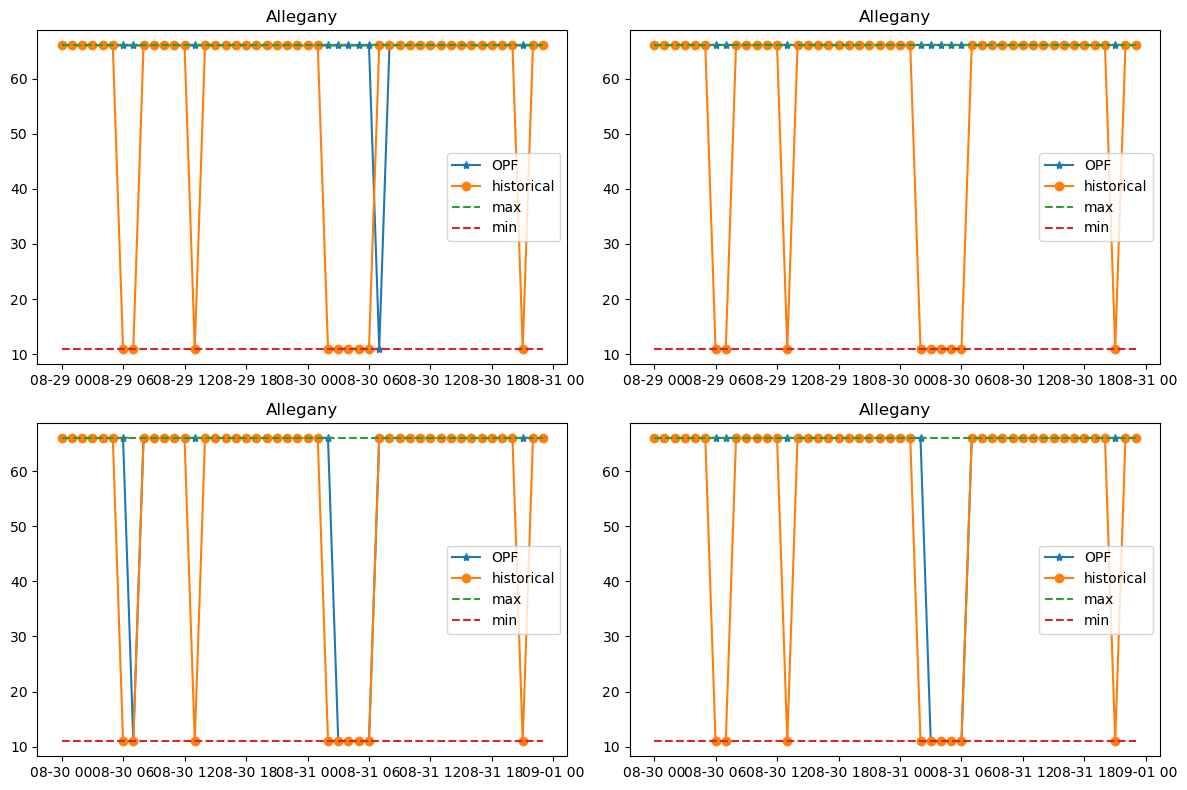

In [31]:
ii = 3
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()

NYISOName            Astoria 2
PTID                     24149
Zone                         J
UnitType         Steam Turbine
FuelType           Natural Gas
Latitude               40.7869
Longitude             -73.9122
maxPower                 153.0
minPower                   1.0
maxRampAgc                15.3
maxRamp10                153.0
maxRamp30                153.0
maxRamp60                153.0
HeatRateLM_1         10.720159
HeatRateLM_0        147.545513
HeatRateLM_R2         0.987563
HeatRateQM_2          0.007555
HeatRateQM_1          9.621049
HeatRateQM_0        170.560114
HeatRateQM_R2          0.98891
useQM                        1
start-time                 10m
Name: 9, dtype: object


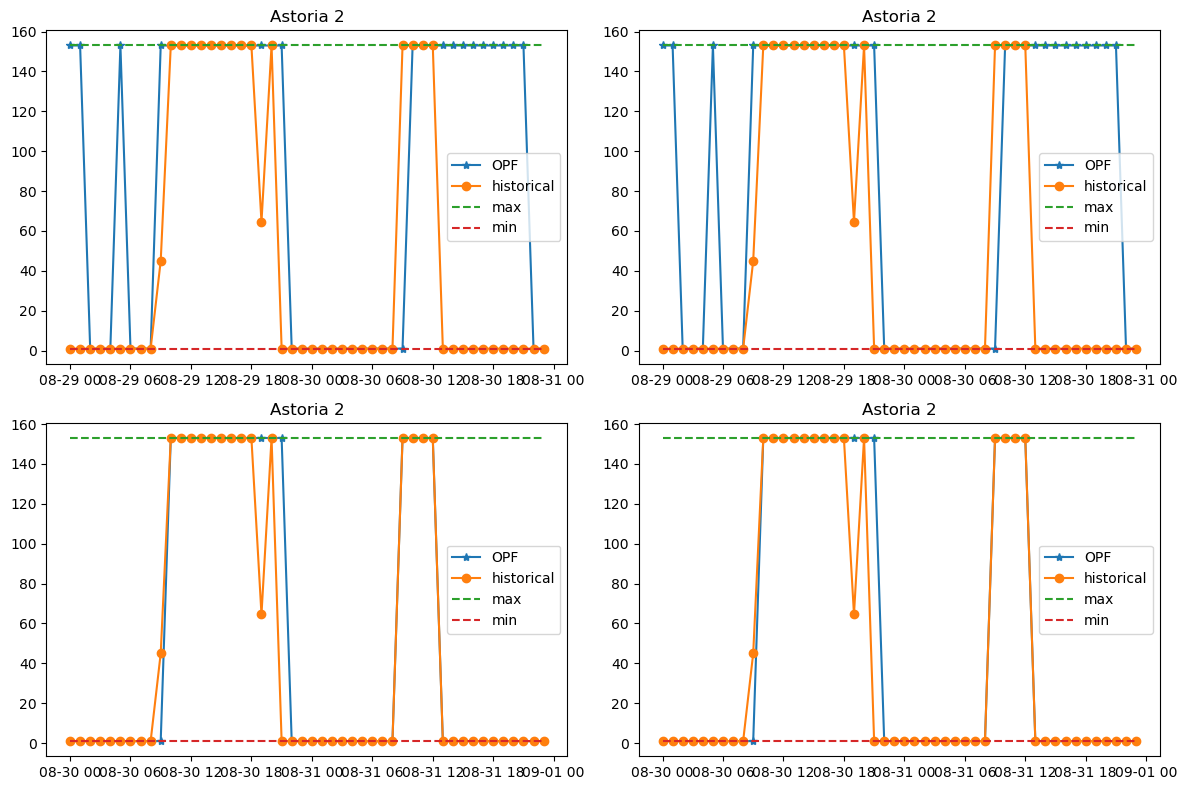

In [32]:
ii = 9
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
fig.tight_layout()


NYISOName          East River 2
PTID                     323559
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7281
Longitude              -73.9742
maxPower                  227.0
minPower                   83.0
maxRampAgc                2.325
maxRamp10                 23.25
maxRamp30                 69.75
maxRamp60                 139.5
HeatRateLM_1           7.653993
HeatRateLM_0         446.985488
HeatRateLM_R2           0.98562
HeatRateQM_2           0.006054
HeatRateQM_1           5.870358
HeatRateQM_0          567.52178
HeatRateQM_R2          0.986302
useQM                         1
start-time                  12h
Name: 83, dtype: object


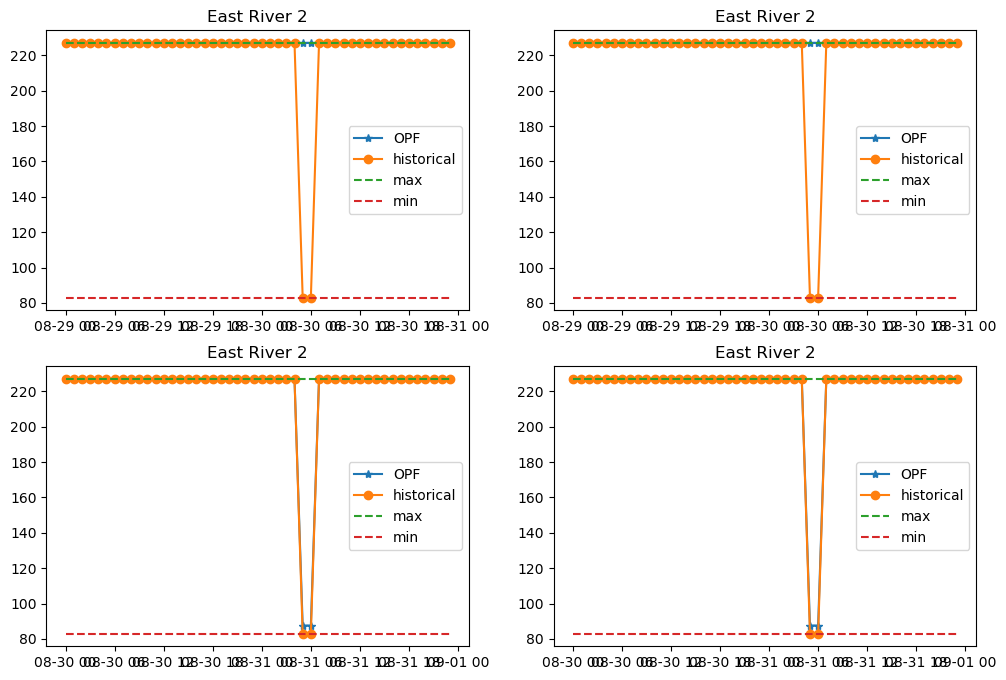

In [33]:
ii = 83
print(gen_info.iloc[ii, :])
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0] = plot_gen(thermal_pg_0_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 0])
axs[0, 1] = plot_gen(thermal_pg_0_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[0, 1])
axs[1, 0] = plot_gen(thermal_pg_1_wo_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 0])
axs[1, 1] = plot_gen(thermal_pg_1_w_esr, gen_profile, genmax_profile, genmin_profile, ii, title=gen_info.NYISOName[ii], ax=axs[1, 1])
plt.show()